In [ ]:
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
import pandas as pd
import tensorflow as tf
from tqdm import tqdm , tqdm_notebook
import numpy as np
import category_encoders as ce
import re
from copy import deepcopy
from Missing_Generate import Gene_Missing
import matplotlib.pyplot as plt

In [2]:
mb_size = 128
# 2. Missing rate
p_miss = 0.2
# 3. Hint rate
p_hint = 0.9
# 4. Loss Hyperparameters
alpha = 2
# 5. Train Rate
train_rate = 0.8
RAW_ = pd.read_csv("/home/advice/Python/SR/Data/Churn.csv")
usecols = RAW_.columns.tolist()
notuse = ['account length' , 'phone number']
for col in notuse :
    usecols.remove(col)

In [3]:
RAW = RAW_[usecols]

In [4]:
category = RAW.select_dtypes("object").columns.tolist() + ["area code" , "churn"]

In [5]:
RAW[category] = RAW[category].astype(str)

/root/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [6]:
obj_col = RAW.select_dtypes("object").columns.tolist()
ord_col = RAW.select_dtypes("int").columns.tolist()
num_col = RAW.select_dtypes("float").columns.tolist()
print(obj_col)
assert len(usecols) == len(obj_col + ord_col + num_col)

['state', 'area code', 'international plan', 'voice mail plan', 'churn']


In [7]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
GMiss = Gene_Missing(RAW ,obj_col , ord_col , num_col , p_miss , minmax)

In [8]:
missing_RAW = GMiss.generate(scale= True)

In [9]:
GMiss.save_info("AE_missing_info.pkl")
missing_info = GMiss.load_info("AE_missing_info.pkl")

AE_missing_info.pkl missing 정보 저장 완료


In [10]:
list(missing_info.keys())

['scaler',
 'missing_matrix',
 'columns',
 'ce_encoder',
 'cat2ord',
 '(ord+1)2cat',
 'obj_info',
 'obj_range',
 'cat_num_idx_info']

In [11]:
obj_info = missing_info["obj_info"]
obj_range = missing_info["obj_range"]

In [12]:
columns = missing_info["columns"]

In [13]:
cat_2_ord = missing_info["cat2ord"]
ord_2_cat = missing_info["(ord+1)2cat"]

In [14]:
result = GMiss.show_data(scale= True)
Data = result.values

In [15]:
cond = missing_info["cat_num_idx_info"]

In [16]:
total_col = columns.copy()

In [17]:
trainX ,testX ,trainM, testM =   GMiss.train_test_split(train_prob= 0.7 , scale = True ,na_gene = False,save = True)

In [18]:
Train_No = len(trainX)

In [19]:
missing_data = deepcopy(testX)
missing_data[(1-testM) == 1] = np.nan

In [20]:
No = len(Data)
Dim = len(Data[0,:]) 
# Hidden state dimensions
H_Dim1 = Dim + int(Dim/2)
H_Dim2 = Dim + int(Dim/4)

In [21]:
# 1. Xavier Initialization Definition

def CatNumEmb(out , cond , batch_size , total_col) :
    for idx in range(len(cond)) :
        try :
            diff = cond[idx+1] - cond[idx] 
            split = tf.slice(out , 
                             [0 , cond[idx] ] ,
                             [batch_size , cond[idx+1]-cond[idx]] ) # 
        except Exception as e :            
            print(e)
            diff = len(total_col) - cond[idx] 
            split = tf.slice(out , 
                             [0 , cond[idx] ] ,
                             [batch_size , diff ] ) # 
        if idx == 0 :
            if diff == 1 :
                first = tf.nn.sigmoid(split)
                arg = tf.nn.sigmoid(split)
            else :
                first = tf.nn.softmax(split)
                arg = tf.expand_dims(tf.argmax(first , axis = 1 ) ,
                                     axis = 1 )
                arg = tf.cast(arg , dtype = tf.float32)
                print(first)
        else :
            if diff == 1 :
                not_first = tf.nn.sigmoid(split)
                ##
                first = tf.concat([first , not_first], axis = 1 )
                arg = tf.concat([arg , not_first], axis = 1 )
            else :
                not_first = tf.nn.softmax(split)
                not_first_arg = tf.expand_dims(tf.argmax(first , axis = 1 ,) ,
                                     axis = 1 )
                not_first_arg = tf.cast(not_first_arg , dtype = tf.float32)
                
                ##
                first = tf.concat([first , not_first], axis = 1 )
                arg = tf.concat([arg , not_first_arg], axis = 1 , )
    return first , arg


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape = size, stddev = xavier_stddev)
    
# Hint Vector Generation
def sample_M(m, n, p):
    A = np.random.uniform(0., 1., size = [m, n])
    B = A > p
    C = 1.*B
    return C

tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape = [None, Dim] , name = "true_data")
New_X = tf.placeholder(tf.float32, shape = [None, Dim] , name = "missing_data")
M = tf.placeholder(tf.float32, shape = [None, Dim] , name = "mask_vector")
batch_size = tf.placeholder(tf.int64, name="Batchsize")

H_Dim1 = Dim - 10
H_Dim2 = H_Dim1 - 10
H_Dim3 = H_Dim2 - 10
G_W1 = tf.Variable(xavier_init([Dim, H_Dim1]))     # Data + Mask as inputs (Random Noises are in Missing Components)
G_b1 = tf.Variable(tf.zeros(shape = [H_Dim1]))

G_W2 = tf.Variable(xavier_init([H_Dim1, H_Dim2]))
G_b2 = tf.Variable(tf.zeros(shape = [H_Dim2]))

G_W3 = tf.Variable(xavier_init([H_Dim2, H_Dim3]))
G_b3 = tf.Variable(tf.zeros(shape = [H_Dim3]))
theta_G = [G_W1, G_W2, G_W3, G_b1, G_b2, G_b3]

D_W1 = tf.Variable(xavier_init([H_Dim3, H_Dim2]))     # Data + Hint as inputs
D_b1 = tf.Variable(tf.zeros(shape = [H_Dim2]))

D_W2 = tf.Variable(xavier_init([H_Dim2, H_Dim1]))
D_b2 = tf.Variable(tf.zeros(shape = [H_Dim1]))

D_W3 = tf.Variable(xavier_init([H_Dim1, Dim]))
D_b3 = tf.Variable(tf.zeros(shape = [Dim]))       # Output is multi-variate

theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2, D_b3]

def encoder(x):
    G_h1 = tf.nn.relu(tf.matmul(x, G_W1) + G_b1)
    G_h2 = tf.nn.relu(tf.matmul(G_h1, G_W2) + G_b2)   
    G_prob = tf.nn.sigmoid(tf.matmul(G_h2, G_W3) + G_b3) # [0,1] normalized Output
    return G_prob

def decoder(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)  
    D_h2 = tf.nn.relu(tf.matmul(D_h1, D_W2) + D_b2)
    out = tf.matmul(D_h2, D_W3) + D_b3
    if obj_col is None :
        first = tf.nn.sigmoid(out)
        arg = None
    else :
        first , arg = CatNumEmb(out , cond , batch_size , total_col)
    return first , arg

def sample_Z(m, n):
    return np.random.uniform(0., 1, size = [m, n])    

def sample_idx(m, n):
    A = np.random.permutation(m)
    idx = A[:n]
    return idx

enc = encoder(New_X)
new_x , arg = decoder(enc)

Hat_New_X = X * M + new_x * (1-M)
Hat_New_X = tf.identity(Hat_New_X , name = "imputed")

MSE_true_loss = tf.reduce_mean((M * new_x - M * X)**2) / tf.reduce_mean(M)
MSE_missing_loss = tf.reduce_mean(((1-M) * new_x - (1-M) * X)**2) / tf.reduce_mean(1-M)
Loss = MSE_true_loss + 2*MSE_missing_loss                                                                        
solver = tf.train.AdamOptimizer().minimize(Loss, var_list=theta_D + theta_G)

Tensor("Softmax:0", shape=(?, 51), dtype=float32)


W0918 21:05:26.234832 140079462921984 deprecation.py:323] From /root/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


list index out of range


In [22]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
test_loss = []
train_loss = []

In [23]:
epoch = 50000
for it in tqdm_notebook(range(epoch)):    
    
    #%% Inputs
    mb_idx = sample_idx(Train_No, mb_size)
    X_mb = trainX[mb_idx,:]  
    
    Z_mb = sample_Z(mb_size, Dim) 
    M_mb = trainM[mb_idx,:]  
    
    New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  # Missing Data Introduce
    
    _, loss_curr , MSE_true_loss_curr , MSE_test_loss_curr  = sess.run([solver, Loss , 
                                                                   MSE_true_loss , MSE_missing_loss], 
                                                  feed_dict = {M: M_mb, New_X: New_X_mb, X : X_mb , batch_size : mb_size})
    try :
        if min(test_loss) > MSE_test_loss_curr :
            saver.save(sess, './CAT_AE/Model')
    except :
        pass
    train_loss.append(MSE_true_loss_curr)
    test_loss.append(MSE_test_loss_curr)
    
    #%% Intermediate Losses
    if it % 1000 == 0:
        clear_output()
        print('Iter: {}'.format(it))
        print('Total_loss: {:.4}'.format(np.sqrt(loss_curr)))
        print('not_Missing_loss: {:.4}'.format(np.sqrt(MSE_true_loss_curr)))
        print('Missing_loss: {:.4}'.format(np.sqrt(MSE_test_loss_curr)))
        print()
        

Iter: 49000
Total_loss: 0.1869
not_Missing_loss: 0.05135
Missing_loss: 0.127




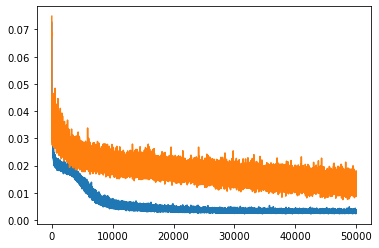

In [24]:

plt.plot(np.arange(epoch) , train_loss)
plt.plot(np.arange(epoch) , test_loss)
plt.show()